In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('/Users/daniel/Princeton Dropbox/Daniel Gurevich/Research/discrete_sr/code/SPIDER_discrete')

In [2]:
import numpy as np

from commons.weight import *
from commons.utils import save, load
from library import *
from process_library_terms import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
#positions, vs, deltat, dims = load('Matt/sim_n64_v03.npy', 4)
#positions, vs, deltat, dims = load('Matt/sim_n1024.npy', 4)
positions, vs, deltat, dims = load('Matt/sim_n1024_default_v2.npy', 4)
print(positions.shape, vs.shape, deltat, dims)

Np, nt = positions.shape[0], positions.shape[2]
world_size = np.array([dims[0], dims[0], dims[1]])
print(world_size)

(1024, 2, 512) (1024, 2, 512) 0.00390625 [  1 512]
[  1   1 512]


0
0
0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510


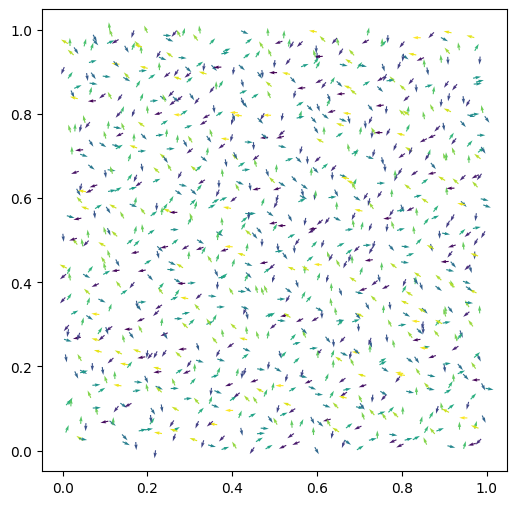

In [4]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = '/Users/daniel/Documents/ffmpeg-7.1/ffmpeg'

vid_file = 'Matt/sim_n1024_default_v2.mp4'

fig, ax = plt.subplots(figsize=(6, 6))
qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

def animate(i):
    if i % 10 == 0:
        print(i)
    qv.set_offsets(positions[:, :, i])
    norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
    qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
    return qv,

anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save(vid_file, writer=FFwriter, dpi=100)

In [5]:
%%prun # profiling

data_dict = {}
data_dict['v'] = vs
v_obs = Observable(string='v', rank=1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
corr_L = 0.05
kernel_sigma = 0.05 # 0.02
cg_res = 256
srd = SRDataset(world_size=world_size, data_dict=data_dict, particle_pos=positions, observables=observables, 
                irreps=SRDataset.all_rank2_irreps(), kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)
v_est = np.mean(np.abs(vs))*2**0.5
print(v_est)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_observables=3, max_rho=2)
srd.make_libraries(max_complexity=5, max_observables=3, max_rho=2)
#srd.make_libraries(max_complexity=6, max_observables=4)

dom_width = 0.3
dom_time = 40
srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4) #*8
srd.make_weights(m=8, qmax=1)
srd.set_LT_scale(L=corr_L, T=corr_L/v_est) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

save('Q_gauss1024.npy', srd)

0.7735843655228972
 

         112444610 function calls (107115857 primitive calls) in 765.526 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4260  534.706    0.126  534.719    0.126 coarse_grain_utils.py:267(poly_coarse_grain_time_slices)
      762   86.968    0.114   88.774    0.117 {built-in method time.sleep}
   639360   23.408    0.000   32.027    0.000 _function_base_impl.py:5078(trapezoid)
   213120   17.250    0.000  614.794    0.003 process_library_terms.py:400(eval_term)
    18180   13.386    0.001   13.399    0.001 diff.py:479(_apply_to_array)
   639360   10.533    0.000   10.892    0.000 polynomial.py:672(polyval)
   213120    9.629    0.000  692.052    0.003 process_library_terms.py:378(eval_on_domain)
  1607687    9.116    0.000    9.116    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   230/32    7.281    0.032    0.001    0.000 {method 'control' of 'select.kqueue' objects}
   213120    5.040    0.000   29.501    0.000 p

In [6]:
# %%prun # profiling

# data_dict = {}
# data_dict['v'] = vs
# v_obs = Observable(string='v', rank=1)
# observables = [v_obs]

# # fix random seed
# np.random.seed(1)

# # initial setup of dataset
# corr_L = 0.05#0.3
# kernel_sigma = 0.02#0.05
# cg_res = 256
# srd = SRDataset(world_size=world_size, data_dict=data_dict, particle_pos=positions, observables=observables, 
#                 irreps=SRDataset.all_rank2_irreps(), kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)
# v_est = np.mean(np.abs(vs))*2**0.5
# print(v_est)

# # initialize libraries, domains, and weights
# #srd.make_libraries(max_complexity=4, max_observables=3, max_rho=2)
# srd.make_libraries(max_complexity=5, max_observables=3, max_rho=2)
# #srd.make_libraries(max_complexity=6, max_observables=4)

# dom_width = 0.3
# dom_time = 20
# srd.make_domains(ndomains=15, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4) #*8
# srd.make_weights(m=8, qmax=1)
# srd.set_LT_scale(L=corr_L, T=corr_L/v_est) # note that this line must go before make_library_matrices
# srd.make_library_matrices(debug=False)

# save('Q_gauss1024.npy', srd.dxs, srd.libs)

In [7]:
from commons.identify_models import *
import copy

#srd = load('Q_gauss1024.npy', 1)
libs = srd.libs

reg_opts_list = []
for irrep in srd.irreps:
    #print(np.linalg.norm(libs[irrep].Q, axis=0))
    # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
    scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=0.8)
    #init = Initializer(method='combinatorial', start_k=3)
    init = Initializer(method='combinatorial', start_k=9999)
    #init = Initializer(method='power', start_k=10)
    #res = Residual(residual_type='fixed_column', anchor_col=0)
    res = Residual(residual_type='dominant_balance')
    #res = Residual(residual_type='matrix_relative')
    
    #iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=10)
    iterator = ModelIterator(max_k=len(libs[irrep].terms), backward_forward=False, max_passes=1)
    thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
    #thres = Threshold(threshold_type='information', ic=AIC)
    
    opts = {'scaler': scaler, 'initializer': init, 'residual': res,
            'model_iterator': iterator, 'threshold': thres}
    opts['verbose'] = False
    opts['inhomog'] = False
    opts['inhomog_col'] = None
    reg_opts_list.append(opts)

eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
#eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in range(len(irreps))], 
reg_opts_list, threshold=5e-2, experimental=True)
#, max_equations=10)

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 3 ---
[0.02 s]
Identified model: ∂t ρ + 1 · ∂α ρ[v_α] = 0 (order 3, train res 6.63e-08, test res 4.79e-08)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 4 ---
[

In [8]:
print(srd.scale_dict)
for irrep in srd.irreps:
    Q = srd.libs[irrep].Q
    [U, S, V] = np.linalg.svd(Q)
    print(np.linalg.norm(Q)/max(S))

{'v': {'mean': np.float64(0.6700384077836976), 'std': np.float64(0.6700384077836977)}, 'rho': {'mean': np.float64(1024.0), 'std': np.float64(65.59999396762103)}}
1.0046163646920871
1.0349665211646788
1.296601063479532
1.0106058029551734


In [9]:
lib1 = libs[srd.irreps[1]]
for i, term, size in zip(list(range(len(lib1.terms))), lib1.terms, lib1.col_weights):
    print(i, term, size, term.complexity)
print(next(regex_find(lib1.terms, r'∂t ρ\[v_α\]')))
print(next(regex_find(lib1.terms, r'ρ · ∂t ρ\[v_α\]')))

0 ρ · ∂α ρ 1343487.8764568786 3
1 ρ · ∂α ∂β² ρ 537395150.5827514 5
2 ρ · ∂t ∂α ρ 20786024.329931978 4
3 ρ · ∂t² ∂α ρ 321594868.86027867 5
4 ρ · ρ[v_α] 702586.1934801985 3
5 ρ · ∂β² ρ[v_α] 18003769.55235736 5
6 ρ · ∂α ∂β ρ[v_β] 18003769.55235736 5
7 ρ · ∂t ρ[v_α] 696371.7323090413 4
8 ρ · ∂t² ρ[v_α] 10774045.694127409 5
9 ρ · ∂α ρ[v_β · v_β] 603160.8542483073 5
10 ρ · ∂β ρ[v_α · v_β] 603160.8542483073 5
11 ρ · ρ[v_α · v_β · v_β] 315427.1028929411 5
12 ∂α ρ 1311.9998793524205 2
13 ∂α ρ · ∂β² ρ 34426873.668415315 5
14 ∂β ρ · ∂α ∂β ρ 34426873.668415315 5
15 ∂α ρ · ∂t ρ 1331604.5611859001 4
16 ∂α ρ · ∂t² ρ 20602169.391847808 5
17 ∂β ρ · ∂β ρ[v_α] 1153366.3808877754 5
18 ∂α ρ · ∂β ρ[v_β] 1153366.3808877754 5
19 ∂β ρ · ∂α ρ[v_β] 1153366.3808877754 5
20 ∂β ρ · ρ[v_α · v_β] 603160.854248307 5
21 ∂α ρ · ρ[v_β · v_β] 603160.854248307 5
22 ∂α ∂β ρ · ρ[v_β] 18003769.552357357 5
23 ∂β² ρ · ρ[v_α] 18003769.552357357 5
24 ∂α ∂β² ρ 524799.9517409682 4
25 ∂t ρ · ∂t ∂α ρ 20602169.391847808 5
26 ∂t ρ · ρ[

In [10]:
lib0 = libs[srd.irreps[0]]
for i, term, size in zip(list(range(len(lib0.terms))), lib0.terms, lib0.col_weights):
    print(i, term, size, term.complexity)
print(next(regex_find(lib0.terms, r'∂α² ρ')))
print(next(regex_find(lib0.terms, r'∂t² ρ')))
print(next(regex_find(lib0.terms, r'∂t ∂α ρ\[v_α\]')))
print(next(regex_find(lib0.terms, r'ρ · ∂α² ρ')))

0 ρ 1024.0 1
1 ρ · ρ 1048576.0 2
2 ρ · ∂α² ρ 26869757.52913757 4
3 ρ · ∂t ρ 1039301.216496599 3
4 ρ · ∂t ∂α² ρ 415720486.59863955 5
5 ρ · ∂t² ρ 16079743.443013934 4
6 ρ · ∂t³ ρ 248780762.58269802 5
7 ρ · ∂α ρ[v_α] 900188.4776178681 4
8 ρ · ∂t ∂α ρ[v_α] 13927434.646180825 5
9 ρ · ρ[v_α · v_α] 470759.7344102811 4
10 ρ · ∂t ρ[v_α · v_α] 466595.8067419255 5
11 ∂α ρ · ∂α ρ 1721343.683420766 4
12 ∂α ρ · ∂t ∂α ρ 26632091.223718 5
13 ∂α ρ · ρ[v_α] 900188.477617868 4
14 ∂α ρ · ∂t ρ[v_α] 892226.19997451 5
15 ∂α² ρ 26239.99758704841 3
16 ∂α² ρ · ∂t ρ 26632091.223718002 5
17 ∂α² ∂β² ρ 10495999.034819363 5
18 ∂t ρ 1014.94259423496 2
19 ∂t ρ · ∂t ρ 1030108.4695923906 4
20 ∂t ρ · ∂t² ρ 15937516.13738784 5
21 ∂t ρ · ∂α ρ[v_α] 892226.19997451 5
22 ∂t ρ · ρ[v_α · v_α] 466595.80674192525 5
23 ∂t ∂α ρ · ρ[v_α] 13927434.646180823 5
24 ∂t ∂α² ρ 405977.03769398393 4
25 ∂t² ρ 15702.874456068295 3
26 ∂t² ∂α² ρ 6281149.7824273165 5
27 ∂t³ ρ 242949.96345966603 4
28 ∂t⁴ ρ 3758845.866735136 5
29 ρ[v_α] · ρ[v_α] 47

In [11]:
print(reg_results[2].all_lambdas, reg_results[2].all_lambdas_test)

[1.433 0.064 0.063 0.041 0.041 0.04  0.04  0.039 0.039 0.038 0.038 0.038
 0.038 0.038 0.038 0.038] [0.83  0.042 0.042 0.024 0.024 0.025 0.025 0.025 0.025 0.025 0.024 0.024
 0.024 0.024 0.024 0.024]


In [18]:
scaler = Scaler(sub_inds=None, char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
#init = Initializer(method='combinatorial', start_k=2)
#init = Initializer(method='combinatorial', start_k=9999)
init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
#res = Residual(residual_type='dominant_balance')
res = Residual(residual_type='matrix_relative')

iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=9)
#iterator = ModelIterator(max_k=len(libs0.terms), backward_forward=True, max_passes=1)

thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
opts['inhomog_col'] = 15 # ∂α² ρ
#opts['inhomog_col'] = 25 # ∂t² ρ

#remove_terms = [7] # rho * dt rho[v_i]
remove_terms = [34, 2] # ∂t ∂α ρ[v_α], ρ · ∂α² ρ
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib0.Q, **opts)
zipped = [(lib0.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)

∂α² ρ + 0.00031155814873270955 · ∂α² ∂β² ρ + -0.17414328351152447 · ∂t² ρ + 0.1665584225453594 · ∂α ∂β ρ[v_α · v_β] = 0 ; residual: 0.008899466485401436


In [19]:
scaler = Scaler(sub_inds=None, char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
#init = Initializer(method='combinatorial', start_k=2)
init = Initializer(method='combinatorial', start_k=9999)
#init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
#res = Residual(residual_type='dominant_balance')
res = Residual(residual_type='matrix_relative')

#iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=10)
iterator = ModelIterator(max_k=len(lib1.terms), backward_forward=True, max_passes=1)

thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
opts['inhomog_col'] = 41 # dt rho[v_i]
opts['verbose'] = False

remove_terms = [7] # rho * dt rho[v_i]
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib1.Q, **opts)
zipped = [(lib1.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)

0.004245907670131237 · ρ · ∂α ρ + ∂t ρ[v_α] + 0.9307876179553886 · ∂β ρ[v_α · v_β] = 0 ; residual: 0.16466995945030805


In [14]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['1', 'rho', 'rho * rho']
#continuity_terms = ['rho * rho[v_j * v_j]', 'rho[v_j] * rho[v_j]', 'rho']
#continuity_terms = ['rho * dt rho', 'rho * dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(libs[0].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

NameError: name 'find_term' is not defined